<a href="https://colab.research.google.com/github/mtcarilli/monod/blob/nn-integration/nn_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf monod

In [2]:
!git clone -b nn-integration https://github.com/pachterlab/monod.git

Cloning into 'monod'...
remote: Enumerating objects: 865, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 865 (delta 107), reused 98 (delta 76), pack-reused 680
Receiving objects: 100% (865/865), 2.26 MiB | 8.05 MiB/s, done.
Resolving deltas: 100% (480/480), done.


In [3]:
import sys
sys.path.insert(0, '/content/monod/src')

In [4]:
import monod
from monod import cme_toolbox

Using device:  cuda


In [5]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt

In [6]:
b = 10
beta = 1.4
gamma = 0.5
p = np.log10(np.asarray([b,beta,gamma]))

In [54]:
limits = [500,500]

In [55]:
model_baseline = monod.cme_toolbox.CMEModel('Bursty','None')

In [56]:
Pss_baseline = model_baseline.eval_model_pss(p,limits)
Pss_small_grid = model_baseline.eval_model_pss(p,limits=[50,50])

(-0.5, 30.5)

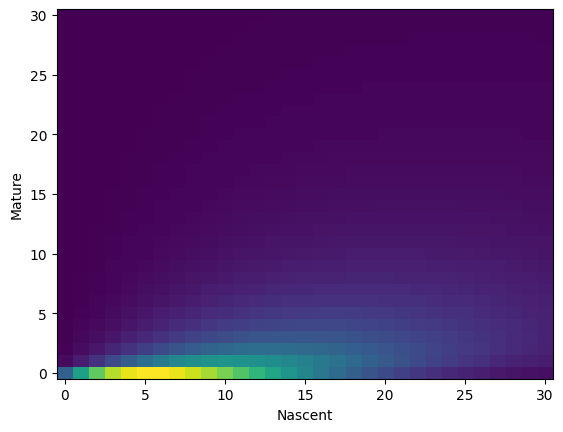

In [57]:
plt.imshow(np.log10(Pss_baseline),aspect='auto')
plt.imshow((Pss_baseline),aspect='auto')
plt.gca().invert_yaxis()
plt.xlabel('Nascent')
plt.ylabel('Mature')
plt.xlim([-0.5,30.5])
plt.ylim([-0.5,30.5])

In [58]:
n_cells = 1000
X, Y = np.meshgrid(np.arange(limits[0]), np.arange(limits[1]), indexing="ij")
X = X.flatten()
Y = Y.flatten()
x = np.random.choice(np.arange(len(X)), p=Pss_baseline.flatten(), size=n_cells, replace=True)
raw_counts = np.zeros((2,n_cells),dtype=int)
raw_counts[0] = X[x]
raw_counts[1] = Y[x]


In [59]:
unique, unique_counts = np.unique(
    np.vstack(raw_counts).T, axis=0, return_counts=True
)
frequencies = unique_counts / n_cells
unique = unique.astype(int)
data = (unique, frequencies)


In [60]:
model_baseline.eval_model_kld(p, limits, "None", data)

0.7572823664586457

Text(0, 0.5, 'KLD')

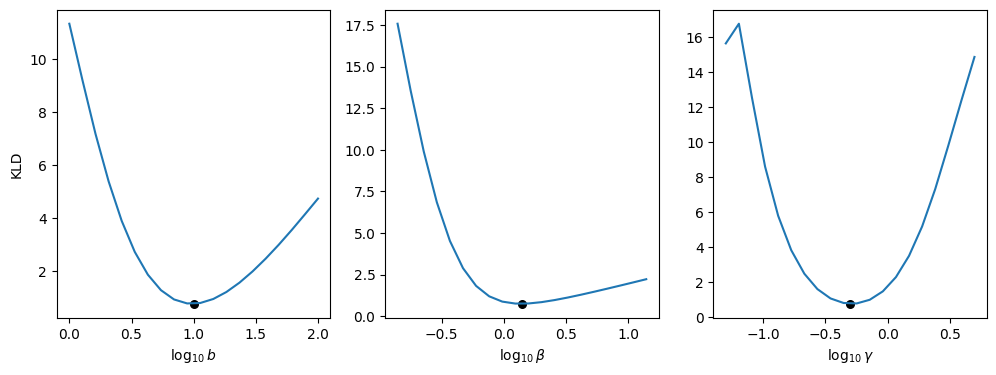

In [61]:
fig1,ax1=plt.subplots(1,3,figsize=(12,4))
param_names = model_baseline.get_log_name_str()
for k in range(3):
    # for 
    domain = p[k] + np.linspace(-1,1,20)
    kld = []
    for d in domain:
        p_ = np.copy(p)
        p_[k] = d
        kld_ = model_baseline.eval_model_kld(p_, limits, "None", data)
        kld.append(kld_)
    ax1[k].plot(domain,kld)
    kld_ = model_baseline.eval_model_kld(p, limits, "None", data)
    ax1[k].scatter(p[k],kld_,30,'k')
    ax1[k].set_xlabel(param_names[k])
ax1[0].set_ylabel('KLD')

In [62]:
model_nn = monod.cme_toolbox.CMEModel('Bursty','None',quad_method='nn_10')

In [63]:
limits

[500, 500]

In [64]:
Pss = model_nn.eval_model_pss(p,limits)
kld_nn = model_nn.eval_model_kld(p, limits, "None", data)

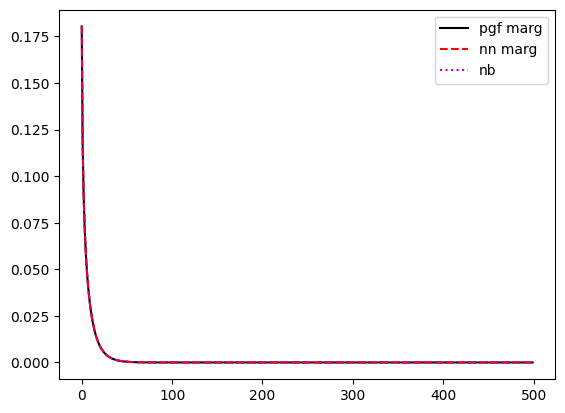

In [65]:

plt.plot(Pss_baseline.sum(1),'k-',label='pgf marg')
plt.plot(Pss.sum(1),'r--',label='nn marg')
x = np.arange(len(Pss))
y = scipy.stats.nbinom.pmf(x,1/beta,1/(1+b))
plt.plot(y,'m:',label='nb')
plt.legend()

(-0.5, 30.5)

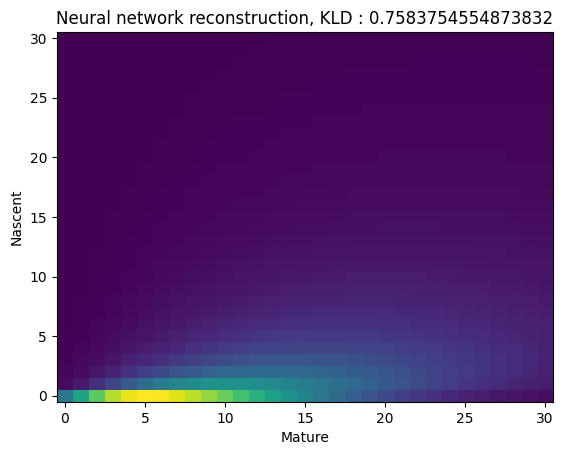

In [66]:
plt.title(f'Neural network reconstruction, KLD : {kld_nn}')
plt.imshow(np.log10(Pss),aspect='auto')
plt.imshow((Pss),aspect='auto')
plt.gca().invert_yaxis()
plt.xlabel('Mature')
plt.ylabel('Nascent')
plt.xlim([-0.5,30.5])
plt.ylim([-0.5,30.5])

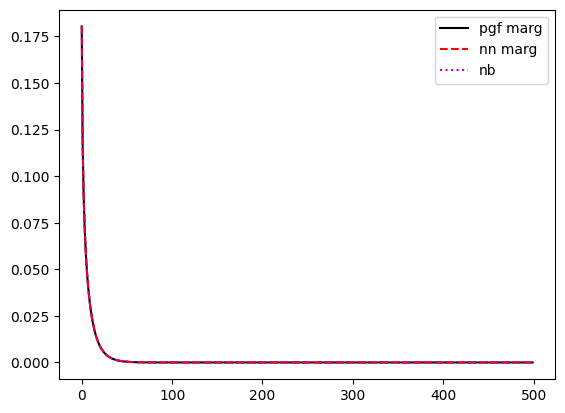

In [67]:
plt.plot(Pss_baseline.sum(1),'k-',label='pgf marg')
plt.plot(Pss.sum(1),'r--',label='nn marg')
x = np.arange(len(Pss))
y = scipy.stats.nbinom.pmf(x,1/beta,1/(1+b))
plt.plot(y,'m:',label='nb')
plt.legend()

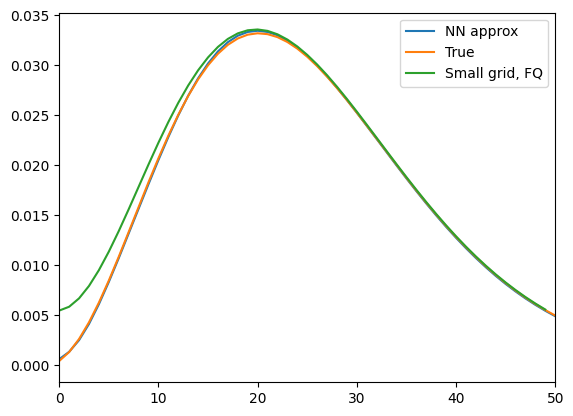

In [68]:
N = 10
plt.plot(Pss[N,:]/np.sum(Pss[N,:]),label = 'NN approx')
plt.plot(Pss_baseline[N,:]/np.sum(Pss_baseline[N,:]),label='True')
plt.plot(Pss_small_grid[N,:]/np.sum(Pss_small_grid[N,:]),label='Small grid, FQ')
plt.xlim(0,50)
plt.legend()

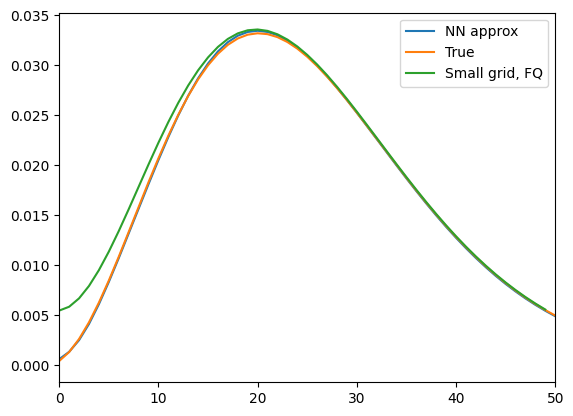

In [69]:
N = 10
plt.plot(Pss[N,:]/np.sum(Pss[N,:]),label = 'NN approx')
plt.plot(Pss_baseline[N,:]/np.sum(Pss_baseline[N,:]),label='True')
plt.plot(Pss_small_grid[N,:]/np.sum(Pss_small_grid[N,:]),label='Small grid, FQ')
plt.xlim(0,50)
plt.legend()

Text(0, 0.5, 'KLD')

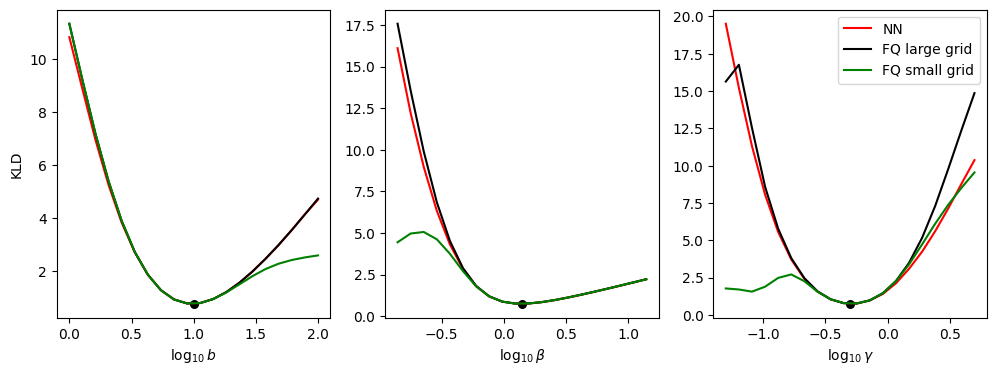

In [77]:
fig1,ax1=plt.subplots(1,3,figsize=(12,4))
param_names = model_nn.get_log_name_str()
for k in range(3):
    # for 
    domain = p[k] + np.linspace(-1,1,20)
    kld = []
    for d in domain:
        p_ = np.copy(p)
        p_[k] = d
        kld_ = model_nn.eval_model_kld(p_, limits, "None", data)
        kld.append(kld_)
    ax1[k].plot(domain,kld,'r-',label='NN')
    kld_ = model_nn.eval_model_kld(p, limits, "None", data)

    kld = []
    for d in domain:
        p_ = np.copy(p)
        p_[k] = d
        kld_ = model_baseline.eval_model_kld(p_, limits, "None", data)
        kld.append(kld_)
    ax1[k].plot(domain,kld,'k-',label = 'FQ large grid')
    kld_ = model_nn.eval_model_kld(p, limits, "None", data)

    kld = []
    for d in domain:
        p_ = np.copy(p)
        p_[k] = d
        kld_ = model_baseline.eval_model_kld(p_, [100,100], "None", data)
        kld.append(kld_)
    ax1[k].plot(domain,kld,'g-',label = 'FQ small grid')
    kld_ = model_nn.eval_model_kld(p, [100,100], "None", data)


    ax1[k].scatter(p[k],kld_,30,'k')
    ax1[k].set_xlabel(param_names[k])
plt.legend()
ax1[0].set_ylabel('KLD')

In [78]:
model_const = monod.cme_toolbox.CMEModel('Constitutive','None')

In [79]:
Pss = model_const.eval_model_pss(p[1:],limits)
kld_const = model_const.eval_model_kld(p[1:], limits, "None", data)

Text(0, 0.5, 'Mature')

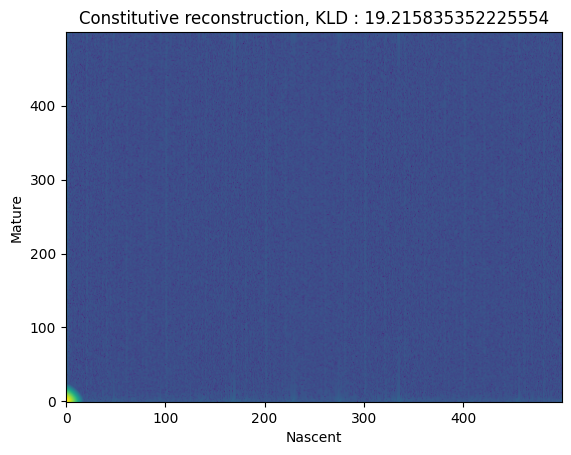

In [80]:
plt.title(f'Constitutive reconstruction, KLD : {kld_const}')
plt.imshow(np.log10(Pss).T,aspect='auto')
plt.gca().invert_yaxis()
plt.xlabel('Nascent')
plt.ylabel('Mature')

# Testing timing

In [81]:
import time

In [84]:
# define models

model_fq = monod.cme_toolbox.CMEModel('Bursty','None')
model_qv = monod.cme_toolbox.CMEModel('Bursty','None',quad_method = 'quad_vec')
model_nn_10 = monod.cme_toolbox.CMEModel('Bursty','None',quad_method = 'nn_10')

In [88]:
limits = [[i,i+1] for i in range(3,500)]

quad_vec = np.ones(len(limits))
fq = np.ones(len(limits))
# nn = np.ones(len(limits))
nn_10 = np.ones(len(limits))

In [89]:
for i,lm in enumerate(limits):
    
    
    # quad vec
    t1 = time.time()
    y_quadvec = model_qv.eval_model_pss(p,lm)
    t2 = time.time()
    quad_vec[i] = t2-t1
    
    # fixed quad  
    t1 = time.time()
    y_fq = model_fq.eval_model_pss(p,lm)
    t2 = time.time()
    fq[i] = t2-t1


    
    # # nnNB NEW approximation 
    # t1 = time.time()
    # y_nn = model_nn.eval_model_pss(p,lm)
    # t2 = time.time()
    # nn[i] = t2-t1

        # nn10 approximation 
    t1 = time.time()
    y_nn_10 = model_nn_10.eval_model_pss(p,lm)
    t2 = time.time()
    nn_10[i] = t2-t1



KeyboardInterrupt: ignored

In [ ]:
x = np.arange(len(limits))

plt.scatter(x,quad_vec,label='quad_vec',s=2)
plt.scatter(x,fq,label='fixed_quad',s=2)
plt.scatter(x,nn_10,label='NN 10',s=2)
# plt.scatter(x[1:],nn[1:],label='nnNB',s=2)
# plt.scatter(x,nn_GCCP,label='nnNB OLD',s=2)

plt.ylabel('Time')
plt.xlabel('One side of grid')
plt.title('Timing over grid')
# plt.xlim(0,100)
# plt.ylim(0,0.02)
plt.legend();

In [ ]:
def get_kld(P,Q):
    ''' Calculate the KLD between P (true) and Q (approximate) distributions.
    '''
    
    P = P.flatten()
    Q = Q.flatten()
    
    Q = Q/np.sum(Q)
    P = P/np.sum(P)
    kld = np.sum( P*torch.log(P/Q + eps) ) 
    
    return(kld)


In [ ]:
# KLDs !!! 
limits = [[i,i+1] for i in range(50,500,10)]

quad_vec_kld = np.ones(len(limits))
fq_kld = np.ones(len(limits))
# nn = np.ones(len(limits))
nn_10_kld = np.ones(len(limits))

# quad vec

y_quadvec = model_qv.eval_model_pss(p,[1000,1000])
TRUE = y_quadvec[:50,:50]

for i,lm in enumerate(limits):
  
    
    # fixed quad  
    t1 = time.time()
    y_fq = model_fq.eval_model_pss(p,lm)
    t2 = time.time()
    kld_ = get_kld(TRUE,y_fq[:50,:50])
    fq_kld[i] = kld_

    
    # # nnNB NEW approximation 
    # t1 = time.time()
    # y_nn = model_nn.eval_model_pss(p,lm)
    # t2 = time.time()
    # nn[i] = t2-t1

        # nnNB NEW approximation 
    t1 = time.time()
    y_nn_10 = model_nn_10.eval_model_pss(p,lm)
    t2 = time.time()
    kld_ = get_kld(TRUE,y_nn_10[:50,:50])
    nn_10_kld[i] = kld_

In [ ]:
#!pip install line-profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from line_profiler import LineProfiler

In [ ]:
#from monod.nn_toolbox import bursty_none_grid
#from monod.nn_toolbox import log_prob_1NB

In [ ]:
#import monod.nn_toolbox as nn_toolbox

In [ ]:
# lp = LineProfiler()
# lp_wrapper = lp(nn_toolbox.log_prob_1NB)
# lp_wrapper(p,np.arange(50),np.arange(50),grid=True)
# lp.print_stats()

Timer unit: 1e-09 s

Total time: 0.0157965 s
File: /content/monod/src/monod/nn_toolbox.py
Function: log_prob_1NB at line 392

Line #      Hits         Time  Per Hit   % Time  Line Contents
   392                                           def log_prob_1NB(p : np.array, n: np.array, m: np.array,  grid : bool, eps : float = 1e-15):
   393                                               ''' Calculates probability for bursty model given the most accurate trained model.
   394                                                 -----------------------------------
   395                                                 n,m
   396                                                   nascent and mature values over which to calculate probability. Shape of n must equal shape of m.
   397                                                 p
   398                                                   parameters for bursty model: b,beta,gamma (NOT log10)
   399                                                 eps
  